In [1]:
from sklearn import svm
from sklearn import linear_model
import datetime
import numpy as np
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.neural_network import MLPRegressor
from sklearn.linear_model import SGDRegressor
from sklearn.preprocessing import StandardScaler, MinMaxScaler
import matplotlib.pyplot as plt
import math
import joblib
import copy
from sklearn.kernel_ridge import KernelRidge
from statsmodels.tsa.arima_model import ARIMA
from genetic_selection import GeneticSelectionCV
import matplotlib.ticker as ticker

# Read FRED data
djia_stat = {}
news_stat = {}
djia_st = 0

start_date = (datetime.datetime.strptime("2018-11-09", "%Y-%m-%d") - datetime.datetime(1970, 1, 1)).total_seconds()

with open("DJIA.csv", "r") as djia_r:
    djia_r.readline()
    djia_close = []
    for l in djia_r:
        x = l.strip().split(",")
        if x[1] == ".": # Skip days for which there are no values.
            continue
        u = [(datetime.datetime.strptime(x[0], "%Y-%m-%d") - datetime.datetime(1970, 1, 1)).total_seconds(), djia_close[-1] if len(djia_close) != 0 else float(x[1]), djia_close[-2] if len(djia_close) > 1 else float(x[1])]
        if x[0] == "2018-11-09": # Check this date
            djia_st = len(djia_stat)
        v = float(x[1]) # Output value
        djia_close.append(v)
        djia_stat[u[0]] = u[1:] + [v]

with open("DJIAHeadlines.csv", "r") as headlines_r:
    for l in headlines_r:
        vals = l.split(",")
        news_stat[(datetime.datetime.strptime(vals[0], "%Y-%m-%d") - datetime.datetime(1970, 1, 1)).total_seconds()] = [int(x) for x in vals[1:]]

# Toss out any data before start_date
ks = copy.deepcopy(list(djia_stat.keys()))
for k in ks:
    if k < start_date:
        del djia_stat[k]
    
# Assume these will both be arrays.
def dict_zip(djia, other):
    k = djia.keys() # Only use DJIA keys as it is closed more often than the news
    res = []
    for x in k:
        if x not in other.keys():
            continue
        res.append([x] + other[x] + djia[x])
    return res
        
def fit(djia_s):
    djia_in = []
    djia_out = []
    dat_ = djia_s
    dat = []
    
    dat = dat_
    split = int(.8 * len(dat))

    scaler = MinMaxScaler()
    scaler.fit(dat)
    djia_s = scaler.transform(dat)
    
    djia_in = [x[:-1] for x in djia_s]
    djia_out = [x[-1] for x in djia_s]

    djia_in_train = np.array(djia_in[:split])
    djia_out_train = np.array(djia_out[:split])
    djia_in_test = np.array(djia_in[split:])
    djia_out_test = np.array(djia_out[split:])

    m = svm.SVR(C=0.01, cache_size=1000, coef0=djia_out_train[-1], degree=5, epsilon=0.001, gamma='auto', kernel='poly', max_iter=5000, shrinking=True, tol=0.0001, verbose=True)

    model = m.fit(djia_in_train, djia_out_train)
    res = copy.deepcopy(m.predict(djia_in_test))

    m2 = GeneticSelectionCV(m, cv=5, verbose=1, scoring="neg_mean_squared_error", n_population=1000, crossover_proba=0.5, mutation_proba=0.2, n_generations=3000, crossover_independent_proba=0.5, mutation_independent_proba=0.05, tournament_size=3, n_gen_no_change=10, caching=True, n_jobs=10)
    m2.fit(djia_in_train, djia_out_train)

    res2 = m2.predict(djia_in_test)
    
    mk = KernelRidge(alpha=1)
    mk.fit(djia_in_train, djia_out_train)
    res_mk = mk.predict(djia_in_test)
    
    tp = 0
    tn = 0
    fp = 0
    fn = 0
    for i in range(1, len(res)):
        dirres = res[i] - res[i - 1] >= 0
        diract = djia_out_test[i] - djia_out_test[i - 1] >= 0
        if dirres == diract:
            if dirres == True:
                tp += 1
            else:
                tn += 1
        else:
            if dirres == True:
                fp += 1
            else:
                fn += 1

    return (split, djia_out_test, res, res2, res_mk)

c:\users\bcwarner\appdata\local\programs\python\python37\lib\site-packages\sklearn\externals\joblib\__init__.py:15: DeprecationWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=DeprecationWarning)


In [2]:
plt.rcParams['figure.figsize'] = [10, 5]
plt.rcParams['figure.dpi'] = 600

filter_on = False

@ticker.FuncFormatter        
def unix_date_str(n, pos=None):
    return datetime.datetime.fromtimestamp(n).strftime("%Y-%m-%d")

[LibSVM]Selecting features with genetic algorithm.
gen	nevals	avg                          	std                          	min              	max                      
0  	1000  	[-120.01826092    2.996     ]	[1088.85059465    1.18574196]	[-10000.      0.]	[-0.00847251  6.        ]
1  	604   	[-40.01210091   2.979     ]  	[631.18858668   1.11020674]  	[-10000.      0.]	[-0.00847251  6.        ]
2  	614   	[-40.01011269   2.65      ]  	[631.18871266   1.00174847]  	[-10000.      0.]	[-0.00847251  6.        ]
3  	620   	[-10.00927381   2.162     ]  	[316.06931918   0.84720482]  	[-10000.      0.]	[-0.00847251  5.        ]
4  	623   	[-40.00880023   1.685     ]  	[631.18879583   0.80732583]  	[-10000.      0.]	[-0.00847251  4.        ]
5  	617   	[-50.00864934   1.249     ]  	[7.05336186e+02 5.90761373e-01]	[-10000.      0.]	[-0.00847251  4.        ]
6  	627   	[-100.00851687    1.055     ]	[9.94986581e+02 3.06553421e-01]	[-10000.      0.]	[-0.00847251  4.        ]
7  	593   	[-70.00849498 

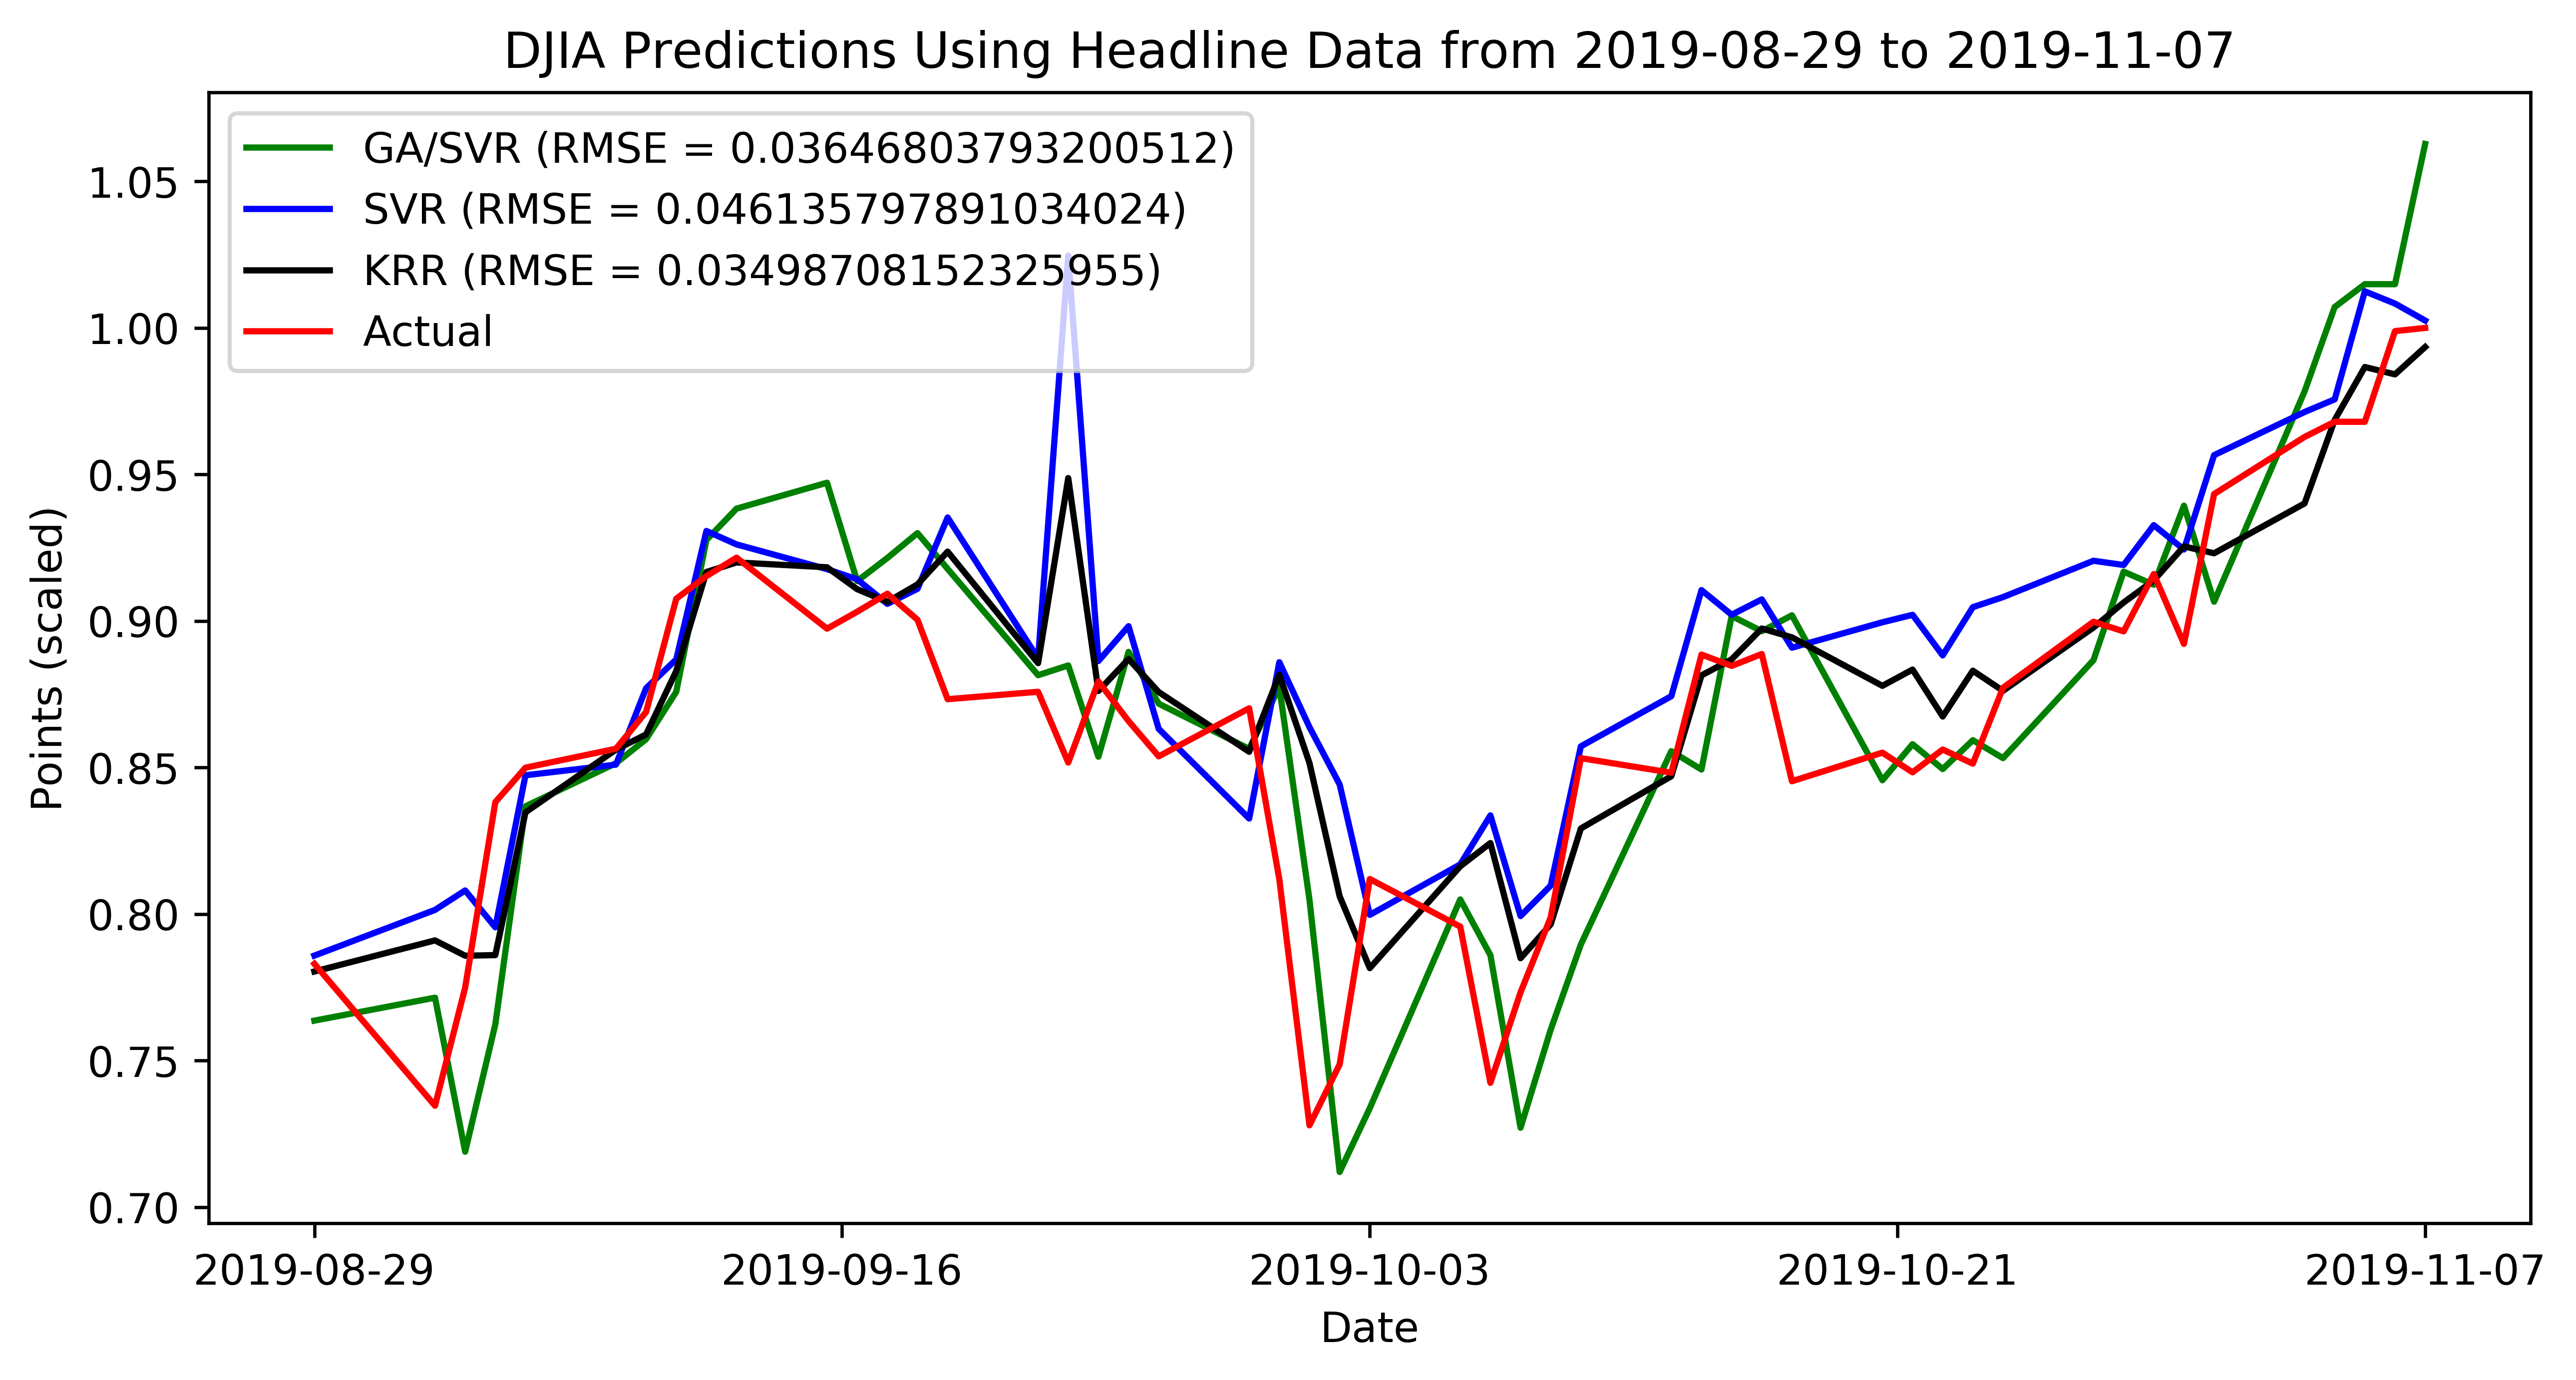

In [3]:
inp = dict_zip(djia_stat, news_stat)
split, actual, res, resga, res_mk = fit(inp)
xs = [x[0] for x in inp[split:]]
plt.plot(xs, resga, "g", label="GA/SVR (RMSE = " + str(math.sqrt(mean_squared_error(actual, resga))) + ")")
plt.plot(xs, res, "b", label="SVR (RMSE = " + str(math.sqrt(mean_squared_error(actual, res))) + ")")
plt.plot(xs, res_mk, "k", label="KRR (RMSE = " + str(math.sqrt(mean_squared_error(actual, res_mk))) + ")")
plt.plot(xs, actual, "r", label="Actual")
plt.title("DJIA Predictions Using Headline Data from " + unix_date_str(xs[0]) + " to " + unix_date_str(xs[-1]) + (", Filtered" if filter_on else ""))
plt.xlabel('Date')
plt.ylabel('Points (scaled)')
plt.xticks(np.linspace(xs[0], xs[-1], 5))
ax = plt.gca()
ax.xaxis.set_major_formatter(unix_date_str)
plt.legend()

[LibSVM]Selecting features with genetic algorithm.
gen	nevals	avg                          	std                            	min              	max                      
0  	1000  	[-260.01593985    2.495     ]	[1.59134902e+03 1.10542978e+00]	[-10000.      0.]	[-0.00847251  5.        ]
1  	590   	[-140.01087852    2.528     ]	[1.17490296e+03 1.05509052e+00]	[-10000.      0.]	[-0.00847251  5.        ]
2  	603   	[-20.00947232   2.147     ]  	[446.76573404   0.89408668]    	[-10000.      0.]	[-0.00847251  5.        ]
3  	625   	[-40.00889966   1.558     ]  	[631.18878953   0.65926929]    	[-10000.      0.]	[-0.00847251  4.        ]
4  	595   	[-60.00854785   1.147     ]  	[7.72268719e+02 3.81301718e-01]	[-10000.      0.]	[-0.00847251  3.        ]
5  	635   	[-70.00851898   1.037     ]  	[8.33725859e+02 2.40064575e-01]	[-10000.      0.]	[-0.00847251  3.        ]
6  	564   	[-100.00848465    1.023     ]	[9.94986584e+02 2.15571334e-01]	[-10000.      0.]	[-0.00847251  3.        ]
7  	610   	[-

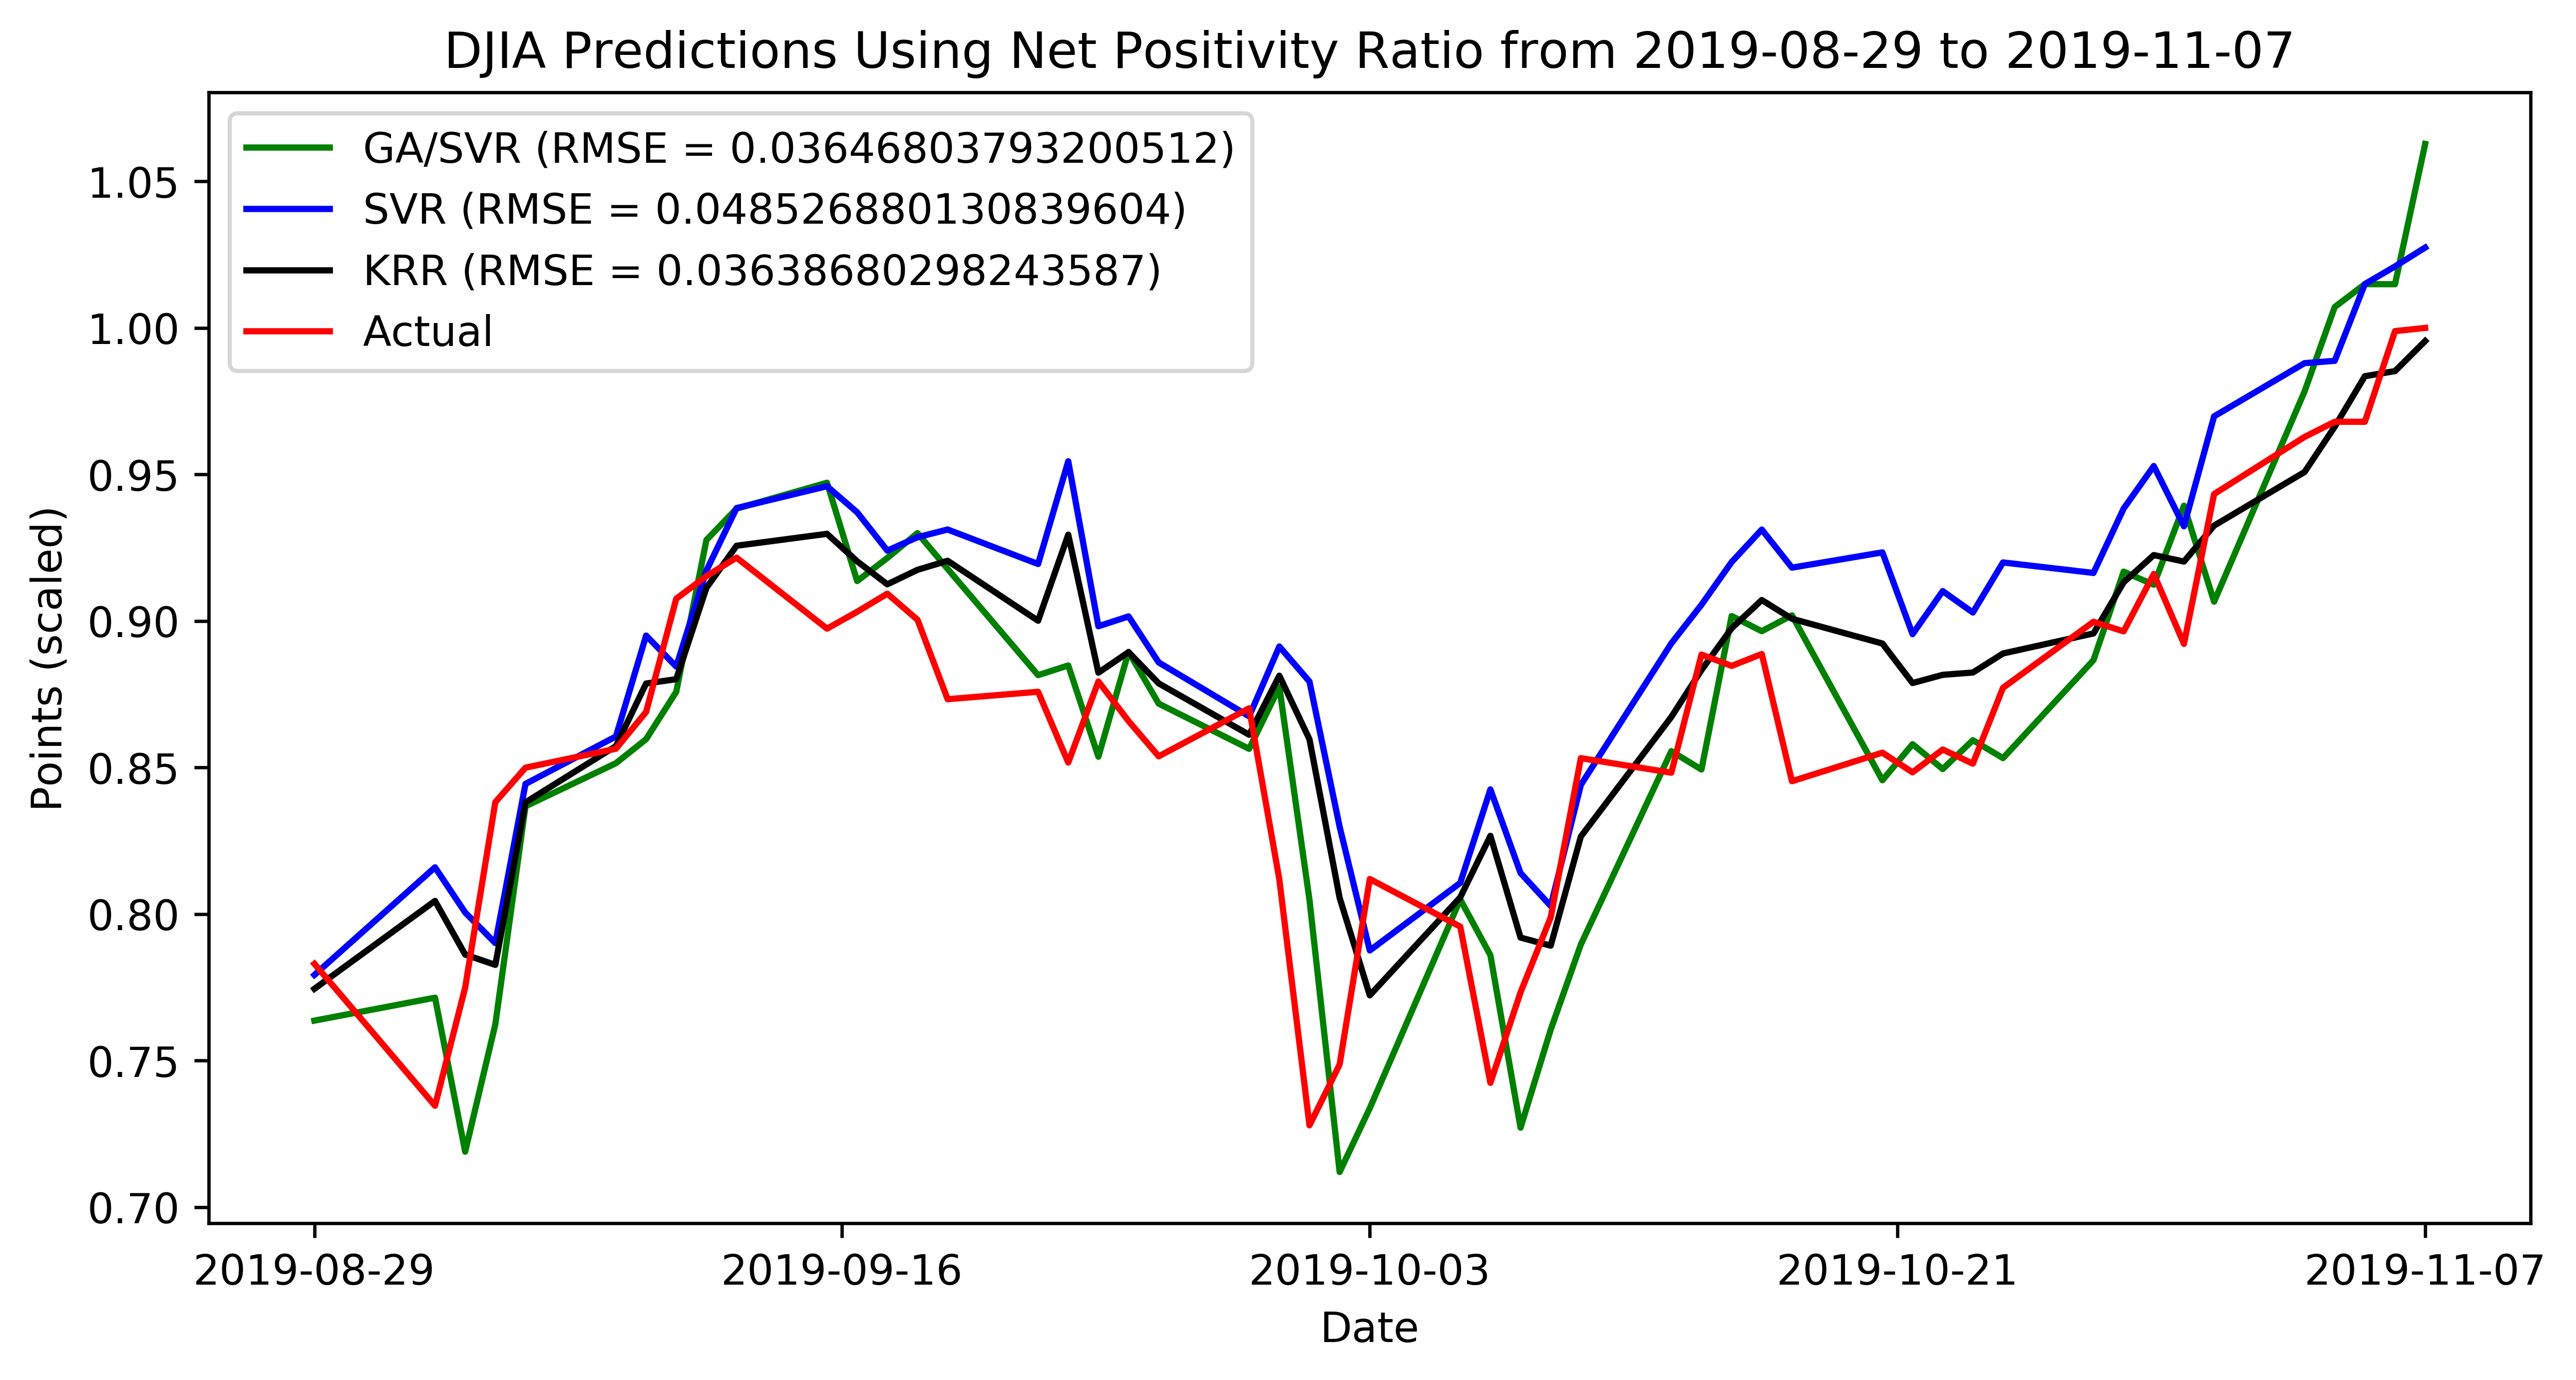

In [4]:
news_stat_ratio = {}
for k, v in news_stat.items():
    news_stat_ratio[k] = [news_stat[k][0],  (news_stat[k][1] - news_stat[k][2]) / (news_stat[k][0])]
    
inp2 = dict_zip(djia_stat, news_stat_ratio)
split, actual, res2, resga2, res_mk2 = fit(inp2)
xs = [x[0] for x in inp2[split:]]
plt.plot(xs, resga2, "g", label="GA/SVR (RMSE = " + str(math.sqrt(mean_squared_error(actual, resga2))) + ")")
plt.plot(xs, res2, "b", label="SVR (RMSE = " + str(math.sqrt(mean_squared_error(actual, res2))) + ")")
plt.plot(xs, res_mk2, "k", label="KRR (RMSE = " + str(math.sqrt(mean_squared_error(actual, res_mk2))) + ")")
plt.plot(xs, actual, "r", label="Actual")
plt.title("DJIA Predictions Using Net Positivity Ratio from " + unix_date_str(xs[0]) + " to " + unix_date_str(xs[-1]) + (", Filtered" if filter_on else ""))
plt.xlabel('Date')
plt.ylabel('Points (scaled)')
plt.xticks(np.linspace(xs[0], xs[-1], 5))
ax = plt.gca()
ax.xaxis.set_major_formatter(unix_date_str)
plt.legend()
plt.show()

[LibSVM]Selecting features with genetic algorithm.
gen	nevals	avg                          	std                            	min              	max                      
0  	1000  	[-410.01575103    2.526     ]	[1.98289866e+03 1.14250777e+00]	[-10000.      0.]	[-0.00847251  5.        ]
1  	602   	[-30.01089326   2.657     ]  	[546.89975902   1.01752199]    	[-10000.      0.]	[-0.00847251  5.        ]
2  	599   	[-0.00942014  2.188     ]    	[0.00139799 0.8903123 ]        	[-0.04032343  1.        ]	[-0.00847251  5.        ]
3  	631   	[-30.00897029   1.576     ]  	[546.8998645    0.66047256]    	[-10000.      0.]        	[-0.00847251  4.        ]
4  	604   	[-40.00863968   1.168     ]  	[6.31188806e+02 4.14458683e-01]	[-10000.      0.]        	[-0.00847251  3.        ]
5  	583   	[-50.00849719   1.056     ]  	[7.05336197e+02 2.84365961e-01]	[-10000.      0.]        	[-0.00847251  4.        ]
6  	600   	[-110.00853217    1.032     ]	[1.04302355e+03 2.42849748e-01]	[-10000.      0.]        

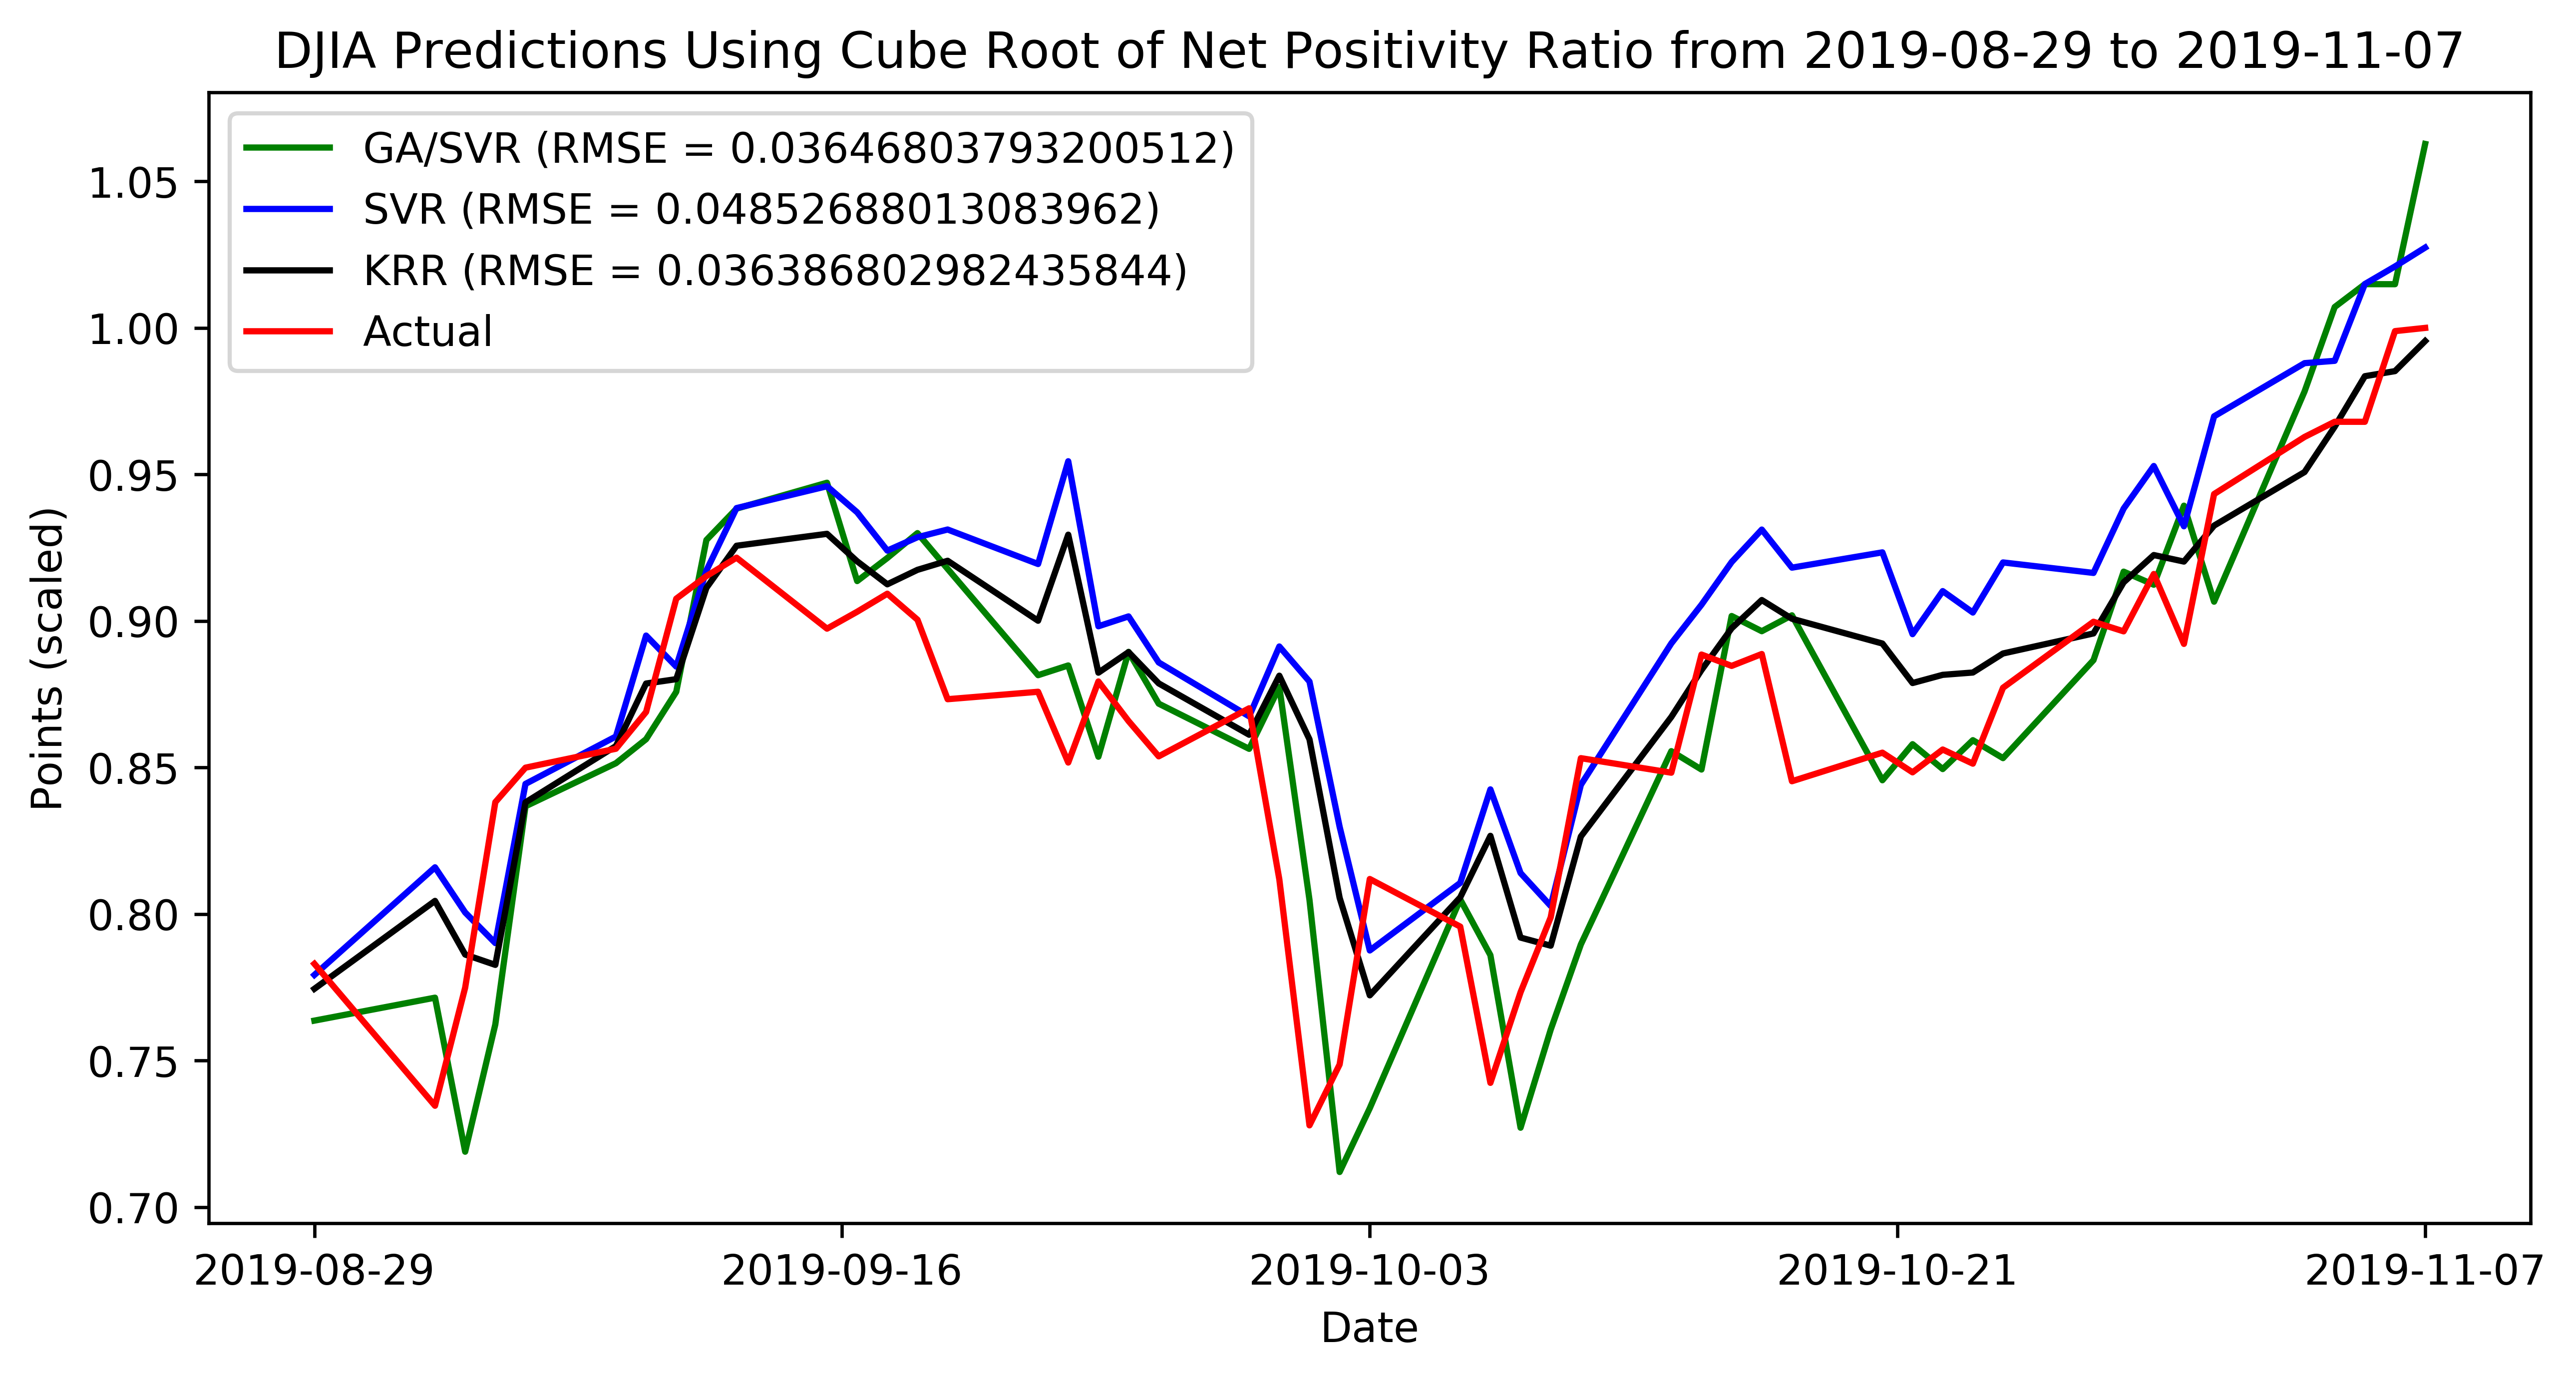

In [5]:

news_stat_ratio_2 = {}
for k, v in news_stat.items():
    news_stat_ratio_2[k] = [news_stat[k][0], ((news_stat[k][1] - news_stat[k][2]) / (news_stat[k][0]) ** 1/3)]
    
inp3 = dict_zip(djia_stat, news_stat_ratio_2)
split, actual, res3, resga3, res_mk3 = fit(inp3)
xs = [x[0] for x in inp3[split:]]
plt.plot(xs, resga3, "g", label="GA/SVR (RMSE = " + str(math.sqrt(mean_squared_error(actual, resga3))) + ")")
plt.plot(xs, res3, "b", label="SVR (RMSE = " + str(math.sqrt(mean_squared_error(actual, res3))) + ")")
plt.plot(xs, res_mk3, "k", label="KRR (RMSE = " + str(math.sqrt(mean_squared_error(actual, res_mk3))) + ")")
plt.plot(xs, actual, "r", label="Actual")
plt.title("DJIA Predictions Using Cube Root of Net Positivity Ratio from " + unix_date_str(xs[0]) + " to " + unix_date_str(xs[-1]) + (", Filtered" if filter_on else ""))
plt.xlabel('Date')
plt.ylabel('Points (scaled)')
plt.xticks(np.linspace(xs[0], xs[-1], 5))
ax = plt.gca()
ax.xaxis.set_major_formatter(unix_date_str)
plt.legend()

In [6]:
control = {}
for k, v in news_stat.items():
    control[k] = []
    
inp4 = dict_zip(djia_stat, control)
split, actual, res4, resga4, res_mk4 = fit(inp4)
xs = [x[0] for x in inp4[split:]]

[LibSVM]Selecting features with genetic algorithm.
gen	nevals	avg                            	std                            	min              	max                      
0  	1000  	[-1300.01092366     1.525     ]	[3.36303012e+03 8.77140240e-01]	[-10000.      0.]	[-0.00847251  3.        ]
1  	598   	[-160.00975518    1.74      ]  	[1.25474973e+03 7.26911274e-01]	[-10000.      0.]	[-0.00847251  3.        ]
2  	619   	[-40.00879339   1.386     ]    	[6.31188796e+02 5.68334409e-01]	[-10000.      0.]	[-0.00847251  3.        ]
3  	576   	[-100.0084602    1.051    ]    	[9.94986587e+02 2.61532025e-01]	[-10000.      0.]	[-0.00847251  2.        ]
4  	588   	[-150.00837613    1.007     ]  	[1.21552354e+03 1.92226429e-01]	[-10000.      0.]	[-0.00847251  2.        ]
5  	633   	[-90.0084163   1.007    ]      	[9.44403772e+02 1.57958855e-01]	[-10000.      0.]	[-0.00847251  2.        ]
6  	609   	[-60.00843833   1.007     ]    	[7.72268727e+02 1.37662631e-01]	[-10000.      0.]	[-0.00847251  2.       

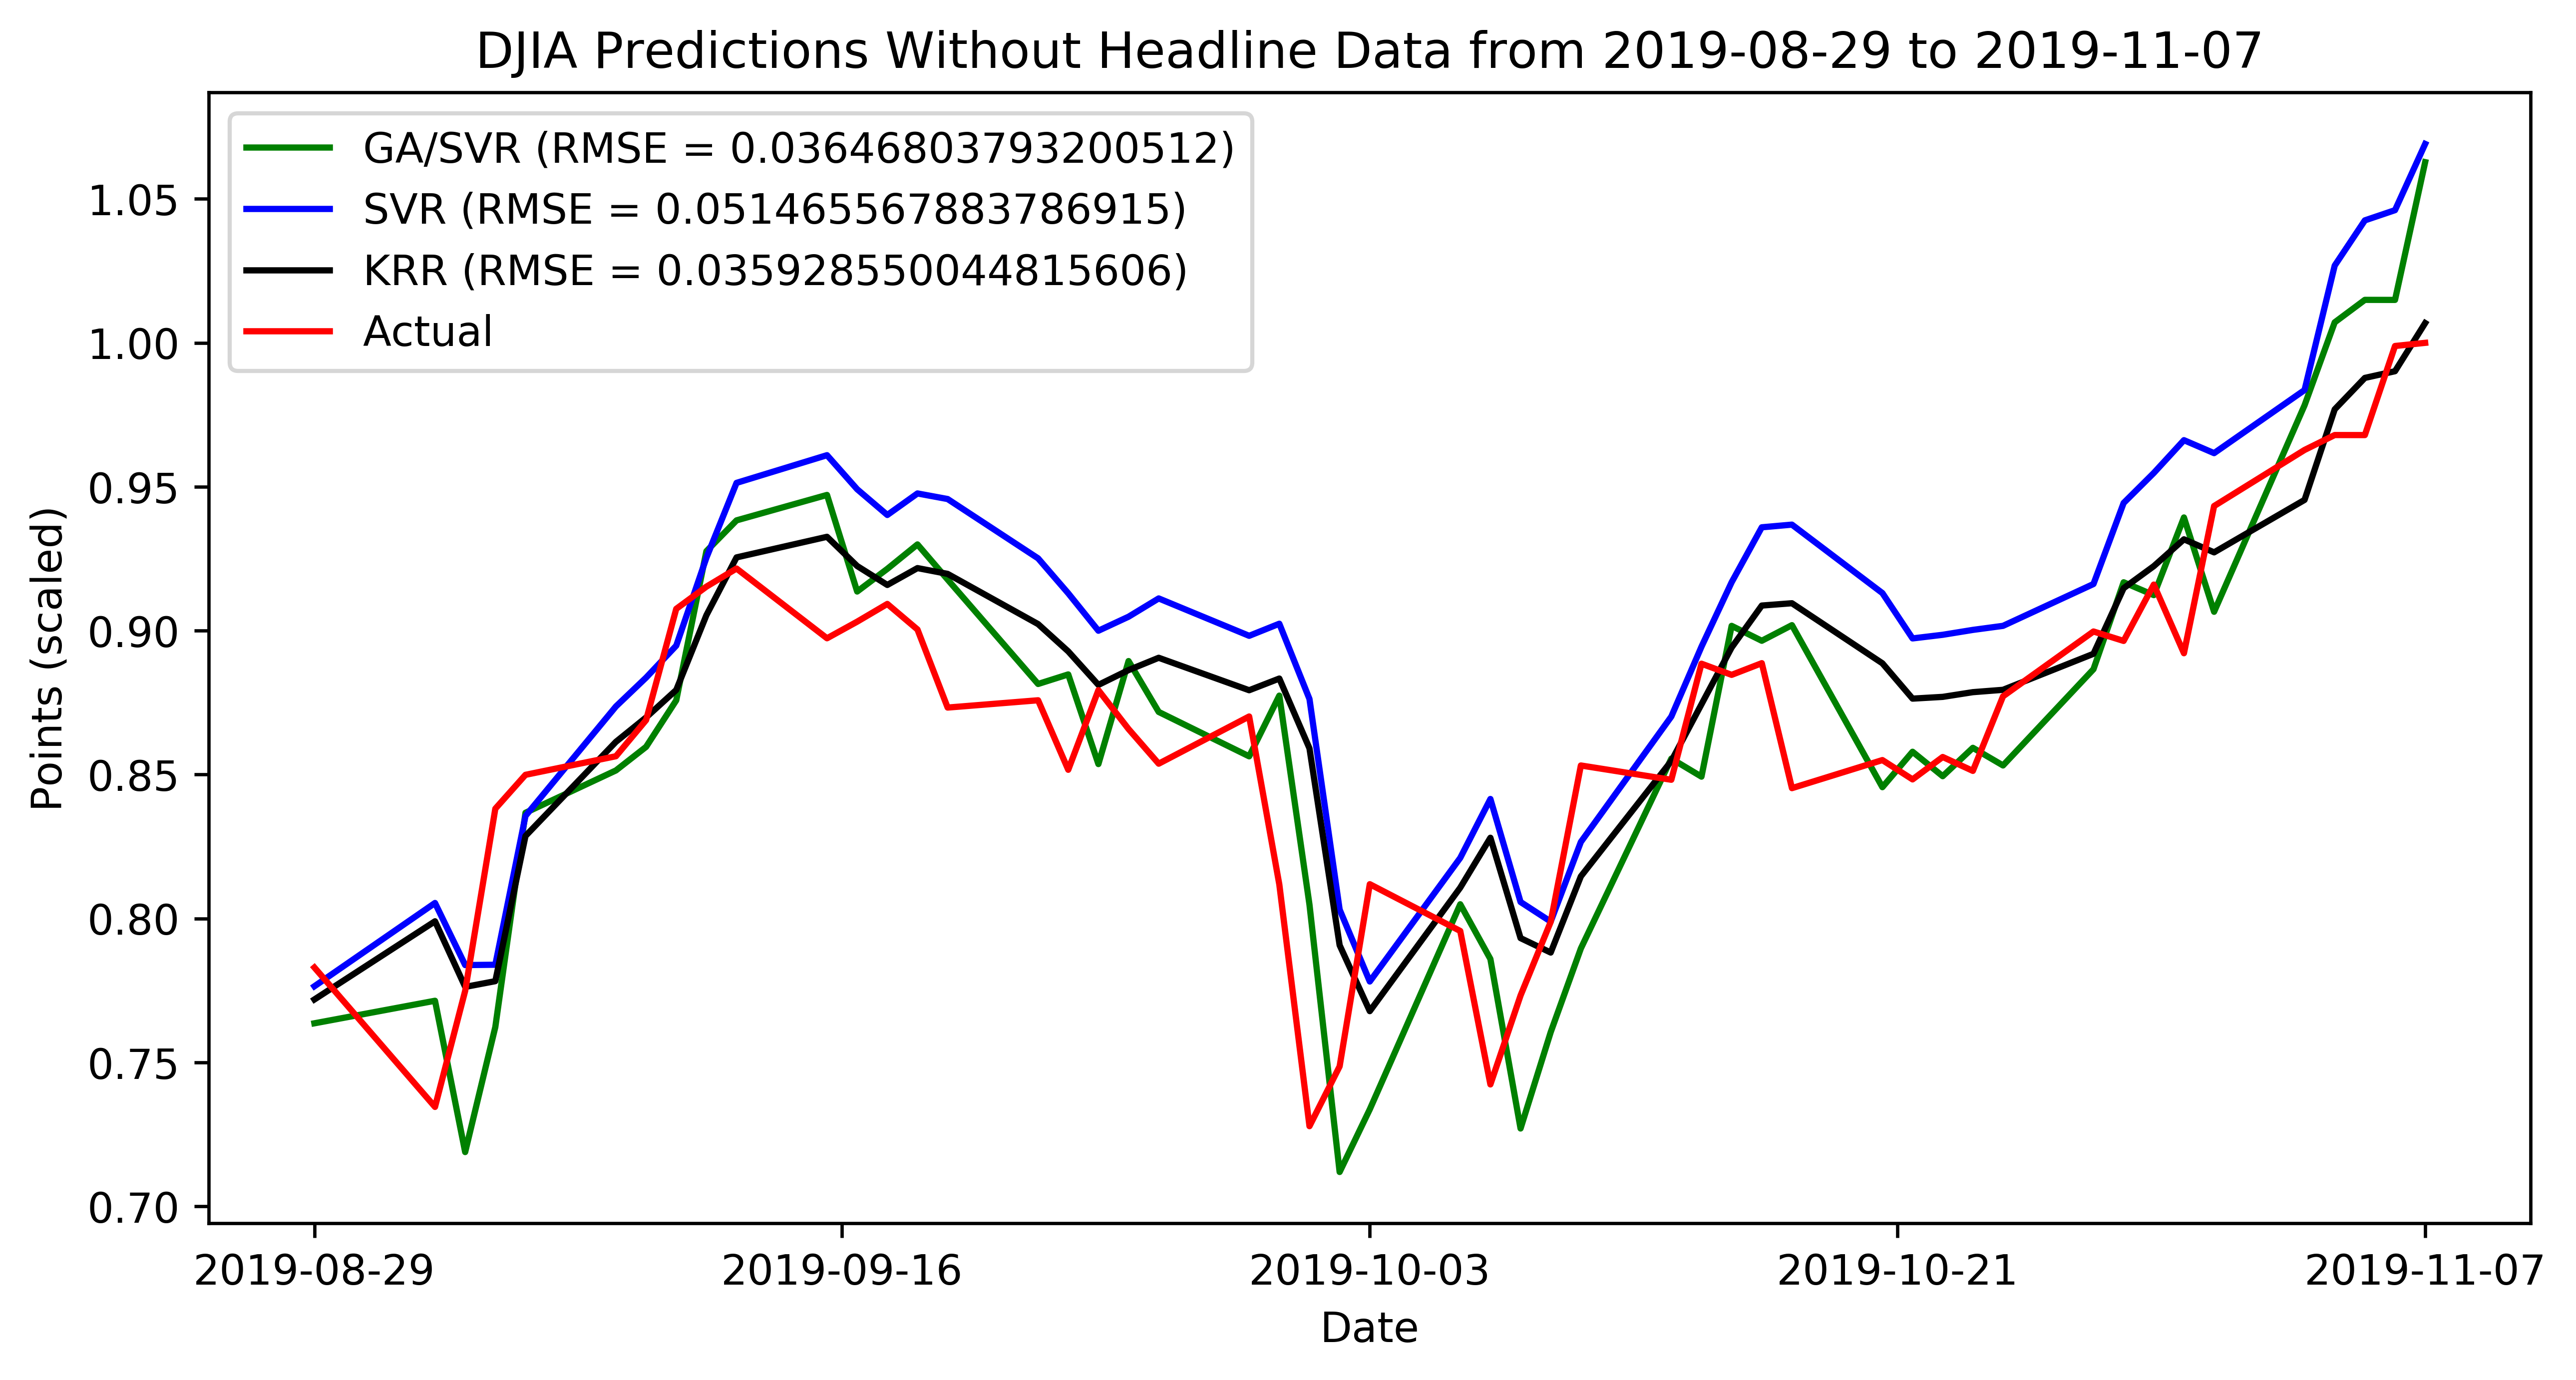

In [7]:
plt.plot(xs, resga4, "g", label="GA/SVR (RMSE = " + str(math.sqrt(mean_squared_error(actual, resga4))) + ")")
plt.plot(xs, res4, "b", label="SVR (RMSE = " + str(math.sqrt(mean_squared_error(actual, res4))) + ")")
plt.plot(xs, res_mk4, "k", label="KRR (RMSE = " + str(math.sqrt(mean_squared_error(actual, res_mk4))) + ")")
plt.plot(xs, actual, "r", label="Actual")
plt.title("DJIA Predictions Without Headline Data from " + unix_date_str(xs[0]) + " to " + unix_date_str(xs[-1]) + (", Filtered" if filter_on else ""))
plt.xlabel('Date')
plt.ylabel('Points (scaled)')
plt.xticks(np.linspace(xs[0], xs[-1], 5))
ax = plt.gca()
ax.xaxis.set_major_formatter(unix_date_str)
plt.ylabel('Points (scaled)')
plt.legend()

[LibSVM]Selecting features with genetic algorithm.
gen	nevals	avg                          	std                            	min              	max                      
0  	1000  	[-260.01514097    2.464     ]	[1.59134915e+03 1.11655900e+00]	[-10000.      0.]	[-0.00847251  5.        ]
1  	573   	[-40.01104046   2.475     ]  	[631.18865387   1.03507246]    	[-10000.      0.]	[-0.00847251  5.        ]
2  	619   	[-50.0095931   2.084    ]    	[705.33611895   0.91046362]    	[-10000.      0.]	[-0.00847251  5.        ]
3  	575   	[-60.00891844   1.538     ]  	[7.72268690e+02 6.78642763e-01]	[-10000.      0.]	[-0.00847251  4.        ]
4  	605   	[-70.00855326   1.13      ]  	[8.33725856e+02 3.64828727e-01]	[-10000.      0.]	[-0.00847251  3.        ]
5  	625   	[-80.00852056   1.035     ]  	[8.90841533e+02 2.27541205e-01]	[-10000.      0.]	[-0.00847251  3.        ]
6  	590   	[-70.00849488   1.032     ]  	[8.33725861e+02 2.30165158e-01]	[-10000.      0.]	[-0.00847251  3.        ]
7  	598   	[-

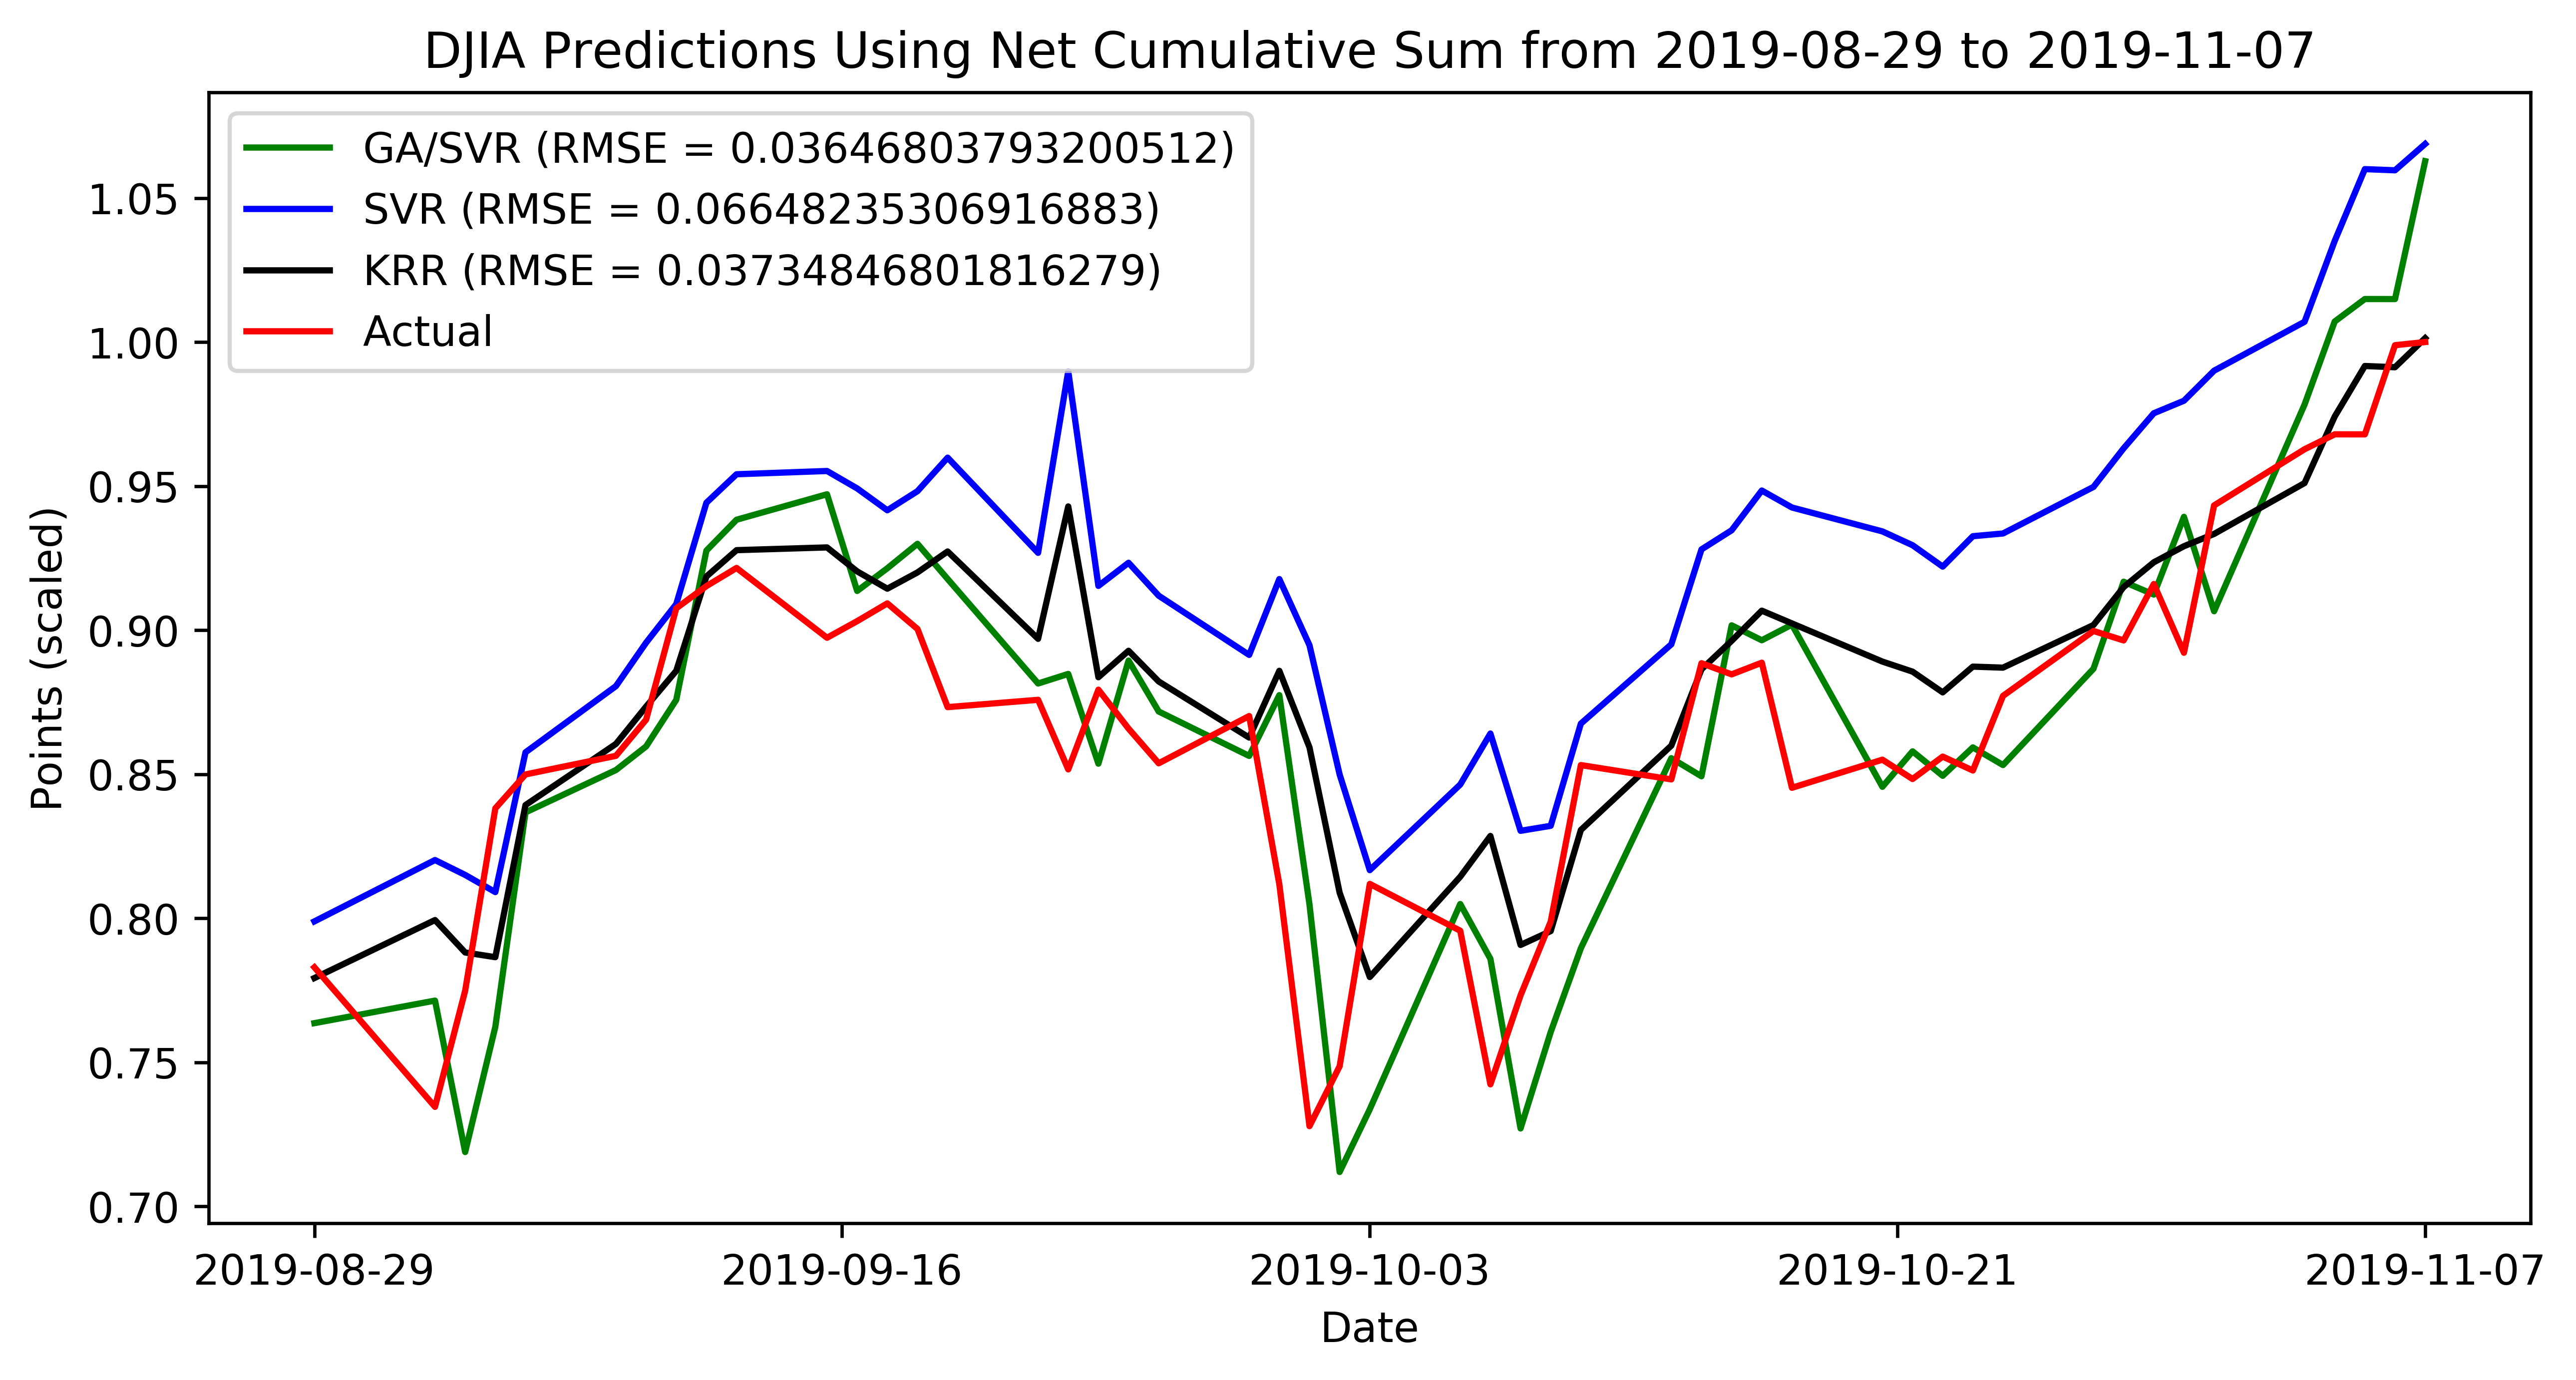

In [10]:
possum = np.cumsum([x[1] for k, x in news_stat.items()]) # if k in djia_stat.keys()])
negsum = np.cumsum([x[2] for k, x in news_stat.items()]) # if k in djia_stat.keys()])
netsum = possum - negsum
netsum_dict = {}
djia_stat_fixed = {}
for k, v in netsum_dict:
    if k in djia_stat.keys():
        djia_stat_fixed[k] = djia_stat[k]

for k, v in zip(news_stat.keys(), netsum):
    netsum_dict[k] = [news_stat[k][0], v]
    
inp5 = dict_zip(djia_stat, netsum_dict)
split, actual, res5, resga5, res_mk5 = fit(inp5)
xs = [x[0] for x in inp5[split:]]
plt.plot(xs, resga5, "g", label="GA/SVR (RMSE = " + str(math.sqrt(mean_squared_error(actual, resga5))) + ")")
plt.plot(xs, res5, "b", label="SVR (RMSE = " + str(math.sqrt(mean_squared_error(actual, res5))) + ")")
plt.plot(xs, res_mk5, "k", label="KRR (RMSE = " + str(math.sqrt(mean_squared_error(actual, res_mk5))) + ")")
plt.plot(xs, actual, "r", label="Actual")
plt.title("DJIA Predictions Using Net Cumulative Sum from " + unix_date_str(xs[0]) + " to " + unix_date_str(xs[-1]) + (", Filtered" if filter_on else ""))
plt.xlabel('Date')
plt.ylabel('Points (scaled)')
plt.xticks(np.linspace(xs[0], xs[-1], 5))
ax = plt.gca()
ax.xaxis.set_major_formatter(unix_date_str)
plt.legend()

In [9]:
print(len(djia_stat.keys()), len(news_stat.keys()))
print([x for x in djia_stat.keys() if x not in news_stat.keys()]) # Apparently Nov 23 and Jan 23 both cause issues?

250 365
[]
